# High res drone imagery with TorchGeo

This notebook demonstrates how to use the `OpenAerialMap` dataset in TorchGeo to train a instance segmentation model for building detection.

**Features showcased:**
1. **Catalog Search:** Querying available imagery using the new `search=True` mode.
2. **Data Download:** Downloading specific high-resolution drone imagery.
3. **Intersection Dataset:** combining raster (OAM) and vector (OSM) data.


In [1]:
import os
from pathlib import Path
from torchgeo.datasets import OpenStreetMap, OpenAerialMap

## 1. Setup Region of Interest

We define a bounding box for **Banepa Municipality, Nepal**. This area has good drone coverage in OpenAerialMap.

![image.png](docs/train_val.png)

In [2]:
WORK_DIR = Path('data/banepa')
os.makedirs(WORK_DIR, exist_ok=True)

TRAIN_BBOX = [
  85.51176609880189,
  27.625518932561256,
  85.52513148143508,
  27.63551883131749
]

TEST_BBOX = [
  85.53039880381334,
  27.62456651360527,
  85.53606027956683,
  27.629042810653335
]

VAL_BBOX = [
  85.51883176039746,
  27.63560,
  85.52308324197179,
  27.63833629629815
]


## 2. Browse Available Imagery

We use `search=True` to query the catalog without downloading files. This allows us to inspect metadata and choose the best image.

In [3]:
print('Searching for available images...')
browser = OpenAerialMap(paths=WORK_DIR, bbox=TRAIN_BBOX, search=True, max_items=5)

if browser.search_results is not None:
    display(browser.search_results.head())

Searching for available images...
Found 4 available images

Use .search_results to view.



,ID,Date,Platform,Provider,GSD,Title
0,6708341a4a0ab60001b0b94d,2024-10-10T20:07:54.049+00:00,satellite,Maxar,0.345278,Maxar 105001003E1F0500 Nepal
1,67084ad84a0ab60001b0b95b,2024-10-10T21:44:56.060+00:00,satellite,Maxar,0.345283,Maxar 1040010095519A00 Nepal
2,62d86c65d8499800053796c4,2022-04-15T19:00:00Z,uav,Geomatics Engineering Society,0.031627,UAV Images of Banepa Municipality
3,59e62b743d6412ef72209204,,satellite,Digital Globe,0.400000,15APR27052125-S3DS_R14C5-054335918020_01_P001.TIF


## 3. Initialize Datasets

We select a specific Image ID from the search results above and download it.
We also download OpenStreetMap building footprints for the same area.

In [4]:
all_datasets = [TRAIN_BBOX, VAL_BBOX, TEST_BBOX ]

In [5]:
# Selected Image ID (from search results above)
IMAGE_ID = '62d86c65d8499800053796c4'
ZOOM_LEVEL = 19
CHIP_SIZE_PX = 512

print('Initializing OpenAerialMap (Image Layer)...')


folder = ['train', 'val', 'test']

i = 0
for bbox_d in all_datasets:
    oam_dataset = OpenAerialMap(
        paths=os.path.join(WORK_DIR,folder[i],'source'),
        bbox=bbox_d,
        zoom=ZOOM_LEVEL,
        download=True,
        image_id=IMAGE_ID,
        tile_size=CHIP_SIZE_PX,
    )
    
    
    print('Initializing OpenStreetMap (Mask Layer)...')
    OSM_CLASSES = [{'name': 'building', 'selector': [{'building': '*'}]}]

    osm_dataset = OpenStreetMap(
        paths=os.path.join(WORK_DIR, folder[i], 'labels'), bbox=bbox_d, classes=OSM_CLASSES, download=True
    )
    
    i += 1

Initializing OpenAerialMap (Image Layer)...
Using OpenAerialMap image: UAV Images of Banepa Municipality
  ID: 62d86c65d8499800053796c4
  Date: 2022-04-15T19:00:00Z
  Platform: uav
  Provider: Geomatics Engineering Society
  GSD: 0.0316273953754
  License: CC-BY-4.0
Starting download of 378 tiles...
Download complete.
Initializing OpenStreetMap (Mask Layer)...
Using OpenAerialMap image: UAV Images of Banepa Municipality
  ID: 62d86c65d8499800053796c4
  Date: 2022-04-15T19:00:00Z
  Platform: uav
  Provider: Geomatics Engineering Society
  GSD: 0.0316273953754
  License: CC-BY-4.0
Starting download of 40 tiles...
Download complete.
Initializing OpenStreetMap (Mask Layer)...
Using OpenAerialMap image: UAV Images of Banepa Municipality
  ID: 62d86c65d8499800053796c4
  Date: 2022-04-15T19:00:00Z
  Platform: uav
  Provider: Geomatics Engineering Society
  GSD: 0.0316273953754
  License: CC-BY-4.0
Starting download of 72 tiles...
Download complete.
Initializing OpenStreetMap (Mask Layer)...


## 4. Intersection Dataset & Sampler

We use the `&` operator to create an IntersectionDataset. This ensures every sample contains both imagery and a corresponding mask. this is done inside the package , lets initialize the configuration with dataloaders

In [6]:
from src.config import Config


cfg = Config()

cfg.data_root = WORK_DIR
cfg.output_dir = 'outputs/banepa_experiment'
cfg.train_regions = ['train']
cfg.val_regions = ['val']
cfg.test_regions = ['test']
cfg.wandb_run_name='notebook_run_banepa'

print(cfg)

Config(data_root=PosixPath('data/banepa'), output_dir='outputs/banepa_experiment', seed=64, train_regions=['train'], val_regions=['val'], test_regions=['test'], val_split=0.2, pretrained_model='facebook/mask2former-swin-base-IN21k-coco-instance', epochs=10, batch_size=8, dice_weight=5.0, mask_weight=5.0, class_weight=5.0, learning_rate=1e-05, weight_decay=0.0001, early_stopping_patience=10, num_workers=31, use_wandb=True, wandb_project='building-seg-mask2former', wandb_run_name='notebook_run_banepa')


## 5. Model Setup

mask2former swin backbone , coco instance 

In [7]:
from src.utils import set_seed
from src.stage1_foundation import Mask2FormerModule
from src.stage1_foundation import OAMDataModule
set_seed(cfg.seed)

model = Mask2FormerModule(cfg)
datamodule = OAMDataModule(cfg)


/home/krschap/foss/high-res-building-seg-swinv2-mask2former/.venv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/krschap/foss/high-res-building-seg-swinv2-mask2former/.venv/lib/python3.13/site-packages/transformers/image_processing_base.py:417: UserWarning: The following named arguments are not valid for `Mask2FormerImageProcessor.__init__` and were ignored: '_max_size', 'reduce_labels'
  image_processor = cls(**image_processor_dict)
Some weights of Mask2FormerForUniversalSegmentation were not initialized from the model checkpoint at facebook/mask2former-swin-base-IN21k-coco-instance and are newly initialized because the shapes did not match:
- class_predictor.weight: found shape torch.Size([81, 256]) in the checkpoint and torch.Size([3, 256]) in the model instantiated
- class_predictor.bias: fou

## 6. Training Loop

In [8]:
from pytorch_lightning.callbacks import EarlyStopping, ModelCheckpoint
from pytorch_lightning.loggers import WandbLogger
import pytorch_lightning as pl

callbacks = [
    EarlyStopping(
        monitor="val_loss",
        patience=cfg.early_stopping_patience,
        mode="min",
    ),
    ModelCheckpoint(
        dirpath=cfg.output_dir,
        filename="best",
        monitor="val_loss",
        mode="min",
        save_top_k=1,
    ),
]

logger = (
    WandbLogger(project=cfg.wandb_project, name=cfg.wandb_run_name)
    if cfg.use_wandb
    else None
)

trainer = pl.Trainer(
    max_epochs=cfg.epochs,
    accelerator="auto",
    devices="auto",
    callbacks=callbacks,
    logger=logger,
    precision="16-mixed",
    default_root_dir=cfg.output_dir,
)

trainer.fit(model, datamodule)


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
You are using a CUDA device ('NVIDIA GeForce RTX 4090 Laptop GPU') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
wandb: WARNING The anonymous setting has no effect and will be removed in a future version.
wandb: [wandb.login()] Loaded credentials for https://api.wandb.ai from /home/krschap/.netrc.
wandb: Currently logged in as: krschap (krschap-ubs) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Finding image,label path for ['train']...
Loading images ...
Loaded 378 image tiles. using crs : GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AXIS["Latitude",NORTH],AXIS["Longitude",EAST],AUTHORITY["EPSG","4326"]] with res (1.341104507446289e-06, 1.1881033085345272e-06)
Loading labels ...


/home/krschap/foss/high-res-building-seg-swinv2-mask2former/.venv/lib/python3.13/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:881: Checkpoint directory /home/krschap/foss/high-res-building-seg-swinv2-mask2former/outputs/banepa_experiment exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/krschap/foss/high-res-building-seg-swinv2-mask2former/.venv/lib/python3.13/site-packages/pytorch_lightning/utilities/model_summary/model_summary.py:242: Precision 16-mixed is not supported by the model summary.  Estimated model size in MB will not be accurate. Using 32 bits instead.

  | Name          | Type                                | Params | Mode  | FLOPs
--------------------------------------------------------------------------------------
0 | model         | Mask2FormerForUniversalSegmentation | 106 M  | eval  | 0    
1 | train_metrics | MetricCollection                    | 0      | train | 0    
2 | val_metrics   | MetricCollection                    |

Loaded 1 mask tiles. using crs : EPSG:4326 with res (0.0001, 0.0001)
Converting RAMPMaskDataset res from (0.0001, 0.0001) to (1.341104507446289e-06, 1.1881033085345272e-06)
Train dataset length: 378
Finding image,label path for ['val']...
Loading images ...
Loaded 40 image tiles. using crs : GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AXIS["Latitude",NORTH],AXIS["Longitude",EAST],AUTHORITY["EPSG","4326"]] with res (1.341104507446289e-06, 1.188076889681311e-06)
Loading labels ...
Loaded 1 mask tiles. using crs : EPSG:4326 with res (0.0001, 0.0001)
Converting RAMPMaskDataset res from (0.0001, 0.0001) to (1.341104507446289e-06, 1.188076889681311e-06)
Val dataset length: 40
Finding image,label path for ['test']...
Loading images ...
Loaded 72 image tiles. using crs : GEOGCS["WGS 84",DATUM["WGS_1984",SPHERO

/home/krschap/foss/high-res-building-seg-swinv2-mask2former/.venv/lib/python3.13/site-packages/pytorch_lightning/utilities/_pytree.py:21: `isinstance(treespec, LeafSpec)` is deprecated, use `isinstance(treespec, TreeSpec) and treespec.is_leaf()` instead.


Sanity Checking DataLoader 0:  50%|█████     | 1/2 [00:00<00:00,  1.79it/s]

/home/krschap/foss/high-res-building-seg-swinv2-mask2former/.venv/lib/python3.13/site-packages/pytorch_lightning/utilities/data.py:79: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 8. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.


train_sampler length 2184                                                  


/home/krschap/foss/high-res-building-seg-swinv2-mask2former/.venv/lib/python3.13/site-packages/pytorch_lightning/utilities/_pytree.py:21: `isinstance(treespec, LeafSpec)` is deprecated, use `isinstance(treespec, TreeSpec) and treespec.is_leaf()` instead.
/home/krschap/foss/high-res-building-seg-swinv2-mask2former/.venv/lib/python3.13/site-packages/pytorch_lightning/loops/fit_loop.py:534: Found 719 module(s) in eval mode at the start of training. This may lead to unexpected behavior during training. If this is intentional, you can ignore this warning.


Epoch 9: 100%|██████████| 273/273 [01:54<00:00,  2.38it/s, v_num=qbxv, train_loss=39.60, val_acc=0.936, val_f1=0.893, val_p=0.878, val_r=0.908]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 273/273 [01:54<00:00,  2.38it/s, v_num=qbxv, train_loss=39.60, val_acc=0.936, val_f1=0.893, val_p=0.878, val_r=0.908]


![train](docs/train_acc.png)
![val](docs/val_acc.png)

## 7. Test

In [9]:
trainer.test(model, datamodule, ckpt_path="best", weights_only=False)

Finding image,label path for ['train']...
Loading images ...
Loaded 378 image tiles. using crs : GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AXIS["Latitude",NORTH],AXIS["Longitude",EAST],AUTHORITY["EPSG","4326"]] with res (1.341104507446289e-06, 1.1881033085345272e-06)
Loading labels ...


Restoring states from the checkpoint path at /home/krschap/foss/high-res-building-seg-swinv2-mask2former/outputs/banepa_experiment/best-v1.ckpt


Loaded 1 mask tiles. using crs : EPSG:4326 with res (0.0001, 0.0001)
Converting RAMPMaskDataset res from (0.0001, 0.0001) to (1.341104507446289e-06, 1.1881033085345272e-06)
Train dataset length: 378
Finding image,label path for ['val']...
Loading images ...
Loaded 40 image tiles. using crs : GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AXIS["Latitude",NORTH],AXIS["Longitude",EAST],AUTHORITY["EPSG","4326"]] with res (1.341104507446289e-06, 1.188076889681311e-06)
Loading labels ...
Loaded 1 mask tiles. using crs : EPSG:4326 with res (0.0001, 0.0001)
Converting RAMPMaskDataset res from (0.0001, 0.0001) to (1.341104507446289e-06, 1.188076889681311e-06)
Val dataset length: 40
Finding image,label path for ['test']...
Loading images ...
Loaded 72 image tiles. using crs : GEOGCS["WGS 84",DATUM["WGS_1984",SPHERO

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/krschap/foss/high-res-building-seg-swinv2-mask2former/outputs/banepa_experiment/best-v1.ckpt


test_sampler length 414


/home/krschap/foss/high-res-building-seg-swinv2-mask2former/.venv/lib/python3.13/site-packages/pytorch_lightning/utilities/_pytree.py:21: `isinstance(treespec, LeafSpec)` is deprecated, use `isinstance(treespec, TreeSpec) and treespec.is_leaf()` instead.


Testing DataLoader 0: 100%|██████████| 51/51 [00:07<00:00,  6.52it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.9299025535583496
         test_f1            0.8432669639587402
        test_loss            25.68537712097168
         test_p             0.7724618911743164
         test_r             0.9283621311187744
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_loss': 25.68537712097168,
  'test_acc': 0.9299025535583496,
  'test_f1': 0.8432669639587402,
  'test_p': 0.7724618911743164,
  'test_r': 0.9283621311187744}]

Finding image,label path for ['train']...
Loading images ...
Loaded 378 image tiles. using crs : GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AXIS["Latitude",NORTH],AXIS["Longitude",EAST],AUTHORITY["EPSG","4326"]] with res (1.341104507446289e-06, 1.1881033085345272e-06)
Loading labels ...
Loaded 1 mask tiles. using crs : EPSG:4326 with res (0.0001, 0.0001)
Converting RAMPMaskDataset res from (0.0001, 0.0001) to (1.341104507446289e-06, 1.1881033085345272e-06)
Train dataset length: 378
Finding image,label path for ['val']...
Loading images ...
Loaded 40 image tiles. using crs : GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],

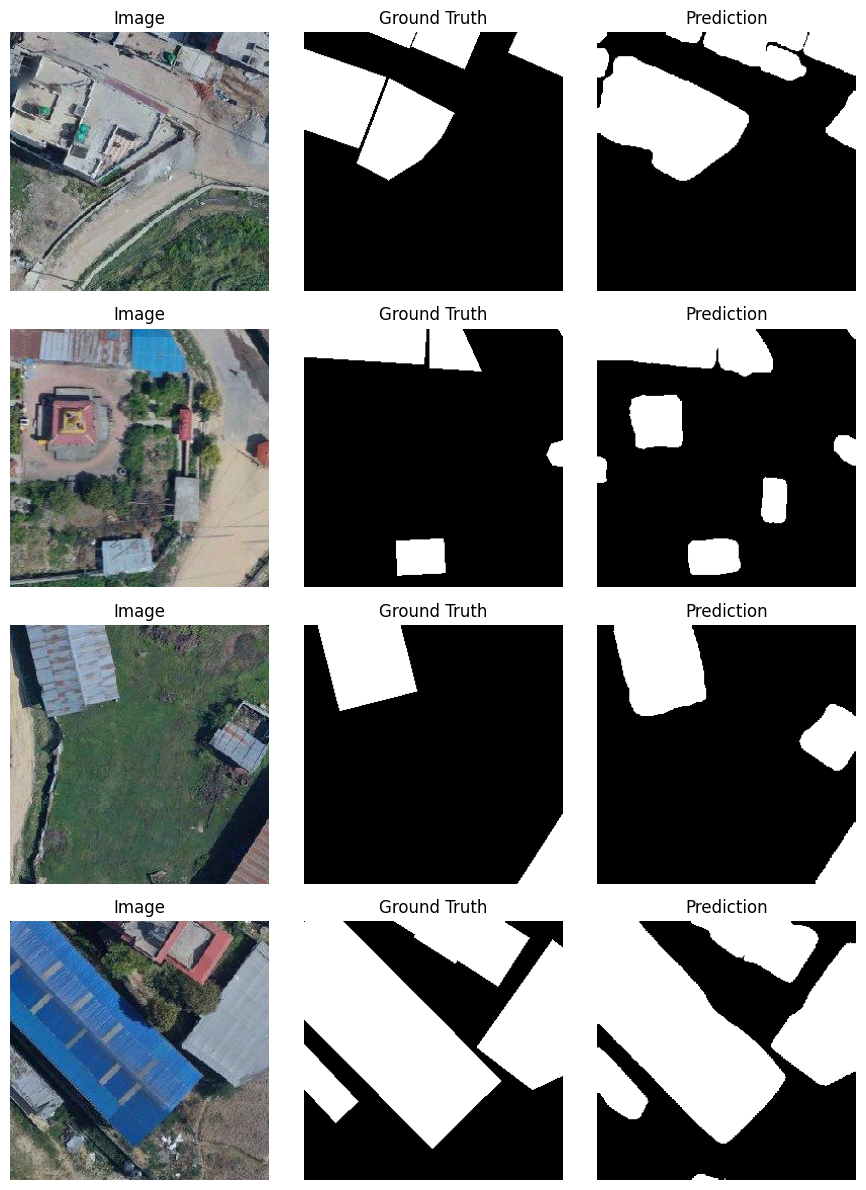

In [10]:
# After training, get a batch and visualize
datamodule.setup()
batch = next(iter(datamodule.test_dataloader()))
model.visualize_batch(batch, num_samples=4, save_path="test_results.png")